In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import scipy.stats as stats
import pandas as pd
import os
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
HOME = os.path.join(os.path.dirname(os.getcwd()), 'results/e2e_profs_new_metrics')
print HOME

/Users/cusgadmin/Desktop/plots-model-comp-paper/results/e2e_profs_new_metrics


In [74]:
import unicodedata
        
def cache_extractions(FN, timestamps=False):
    with open(FN) as json_data:
        d = json.load(json_data)
    all_metrics = d["client_metrics"][0]["all_metrics"]
    result = {}
    for i in range(len(all_metrics)):
        data_lists = all_metrics[i]["data_lists"]
        for item in data_lists:
            key = item.keys()[0]
            key = unicodedata.normalize('NFKD', key).encode('ascii','ignore')
            if result.get(key) == None:
                result[key] = []
            if timestamps:
                data = item[key]["items"]
                data = { k: v for d in data for k, v in d.items() } # consolidate list of dicts
                value = np.concatenate([np.transpose([data.keys()]), np.transpose([data.values()])], axis = 1).astype(float)
            else:
                value = np.asarray(item[key]["items"]).astype(float)
                value = np.concatenate([np.transpose([np.arange(len(value))]), np.transpose([value])], axis = 1).astype(float)
            result[key].append(value)
    import re
    client_timestamps = {}
    for k,v in d["client_metrics"][0].iteritems():
        if re.compile(".+->.+_timestamps").match(k):
            client_timestamps[str(k)] = np.asarray(v)     
    batch_sizes = d["client_metrics"][0]["mean_batch_sizes"]
    for key, value in result.iteritems():
        result[key] = np.concatenate(value)
    str_lats = d["client_metrics"][0]["all_lats"]
    import ast
    lats = [ast.literal_eval(x) for x in str_lats]
    hollistic_data = {}
    hollistic_data["e2e_lats"] = np.asarray(lats).flatten()
    hollistic_data["p99_lats"] = d["client_metrics"][0]["p99_lats"]
    hollistic_data["e2e_thrus"] = d["client_metrics"][0]["thrus"]
    hollistic_data["client_timestamps"] = client_timestamps
    
    return result, hollistic_data

image_driver_1_models = [
    "tf-resnet-feats",
    "tf-log-reg",
    "tf-kernel-svm",
    "inception"
]

ID1_500, ID1_500_hollistic = cache_extractions(HOME+"/"+"incep_1-logreg_1-ksvm_1-resnet_1-180309_063457.json", timestamps=True)
ID1_500_resnet2, ID1_500_hollistic_resnet2 = cache_extractions(HOME+"/"+"incep_1-logreg_1-ksvm_1-resnet_2-180310_212123.json", timestamps=True)

def clean_extraction(extraction):
    # taking off the first 25% of the records to be sure the warmup time is removed
    for key, value in extraction.iteritems():
        sorted_timestamps = np.argsort(value[:,0])
        value = value[sorted_timestamps] # sort data by timestamps
        extraction[key] = value[value.shape[0]/4:] # cut off the first fourth from warmup effects

clean_extraction(ID1_500)
clean_extraction(ID1_500_resnet2)
        
for key, value in ID1_500_resnet2.iteritems():
    print key, value.shape

tf-resnet-feats:1:queue_sizes (45322, 2)
app:tf-kernel-svm:prediction_latencies (29925, 2)
tf-kernel-svm:processing_latency (29926, 2)
model:tf-resnet-feats:1:prediction_latencies_list (15408, 2)
tf-kernel-svm:1:queue_arrivals (29928, 2)
app:tf-resnet-feats:prediction_latencies (29774, 2)
model:inception:1:prediction_latencies_list (18873, 2)
tf-log-reg:processing_latency (29933, 2)
app:inception:prediction_latencies (29772, 2)
inception:1:queue_sizes (48777, 2)
app:tf-log-reg:prediction_latencies (29931, 2)
model:tf-log-reg:1:prediction_latencies_list (29934, 2)
tf-resnet-feats:processing_latency (15406, 2)
tf-resnet-feats:1:processing_outs (25191, 2)
tf-resnet-feats:1:queue_arrivals (29925, 2)
tf-kernel-svm:1:queue_sizes (59851, 2)
tf-log-reg:1:queue_arrivals (29934, 2)
inception:processing_latency (18870, 2)
tf-log-reg:1:queue_sizes (59867, 2)
tf-log-reg:1:processing_outs (29933, 2)
tf-kernel-svm:1:processing_outs (29928, 2)
inception:1:queue_arrivals (29928, 2)
inception:1:processi

In [43]:
import seaborn as sns

def smoothLineHistogram(data, rug=False, label=None):
    sns.distplot(data, rug=rug, label=label)

def lineHistogram(data, label=None):
    y,binEdges=np.histogram(data)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.plot(bincenters,y,'-', label=label)
    
def compare_latency_dists(cached_extractions, model_list):
    plt.figure(figsize=(5*len(model_list),5))
    for i, model in enumerate(model_list):
        plt.subplot(1, len(model_list), i+1)
        plt.title(model+" Processing Latency")
        plt.xlabel("Time (ms)")
        plt.ylabel("Frequency")
        processing_time = cached_extractions[model+":processing_latency"][:,1]
        serving_time = cached_extractions["app:"+model+":prediction_latencies"][:,1]
        serving_time = serving_time/1000 # converting to ms
        processing_time = processing_time[processing_time<1e3]
        serving_time = serving_time[serving_time<1e3]
        smoothLineHistogram(processing_time, label="Processing time")
        smoothLineHistogram(serving_time, label="Processing + Queueing time")
    plt.legend()

def compare_latency_dists_over_time(cached_extractions, model_list):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        processing_time = cached_extractions[model+":processing_latency"][:,1]
        processing_time_timestamps = cached_extractions[model+":processing_latency"][:,0]
        serving_time = cached_extractions["app:"+model+":prediction_latencies"][:,1]
        serving_time = serving_time/1000 # converting to ms
        serving_time_timestamps = cached_extractions["app:"+model+":prediction_latencies"][:,0]
        plt.title(model+" Processing Latency")
        plt.xlabel("timestamp since begining of experiment")
        plt.ylabel("Latency (ms)")
        needlog = True #np.max(intervals) - np.min(intervals) > 10
        bounds = np.asarray([min(np.min(processing_time),np.min(serving_time)), max(np.max(processing_time),np.max(serving_time))])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        plt.scatter(processing_time_timestamps, processing_time, alpha = 0.15)
        plt.scatter(serving_time_timestamps, serving_time, alpha = 0.15)

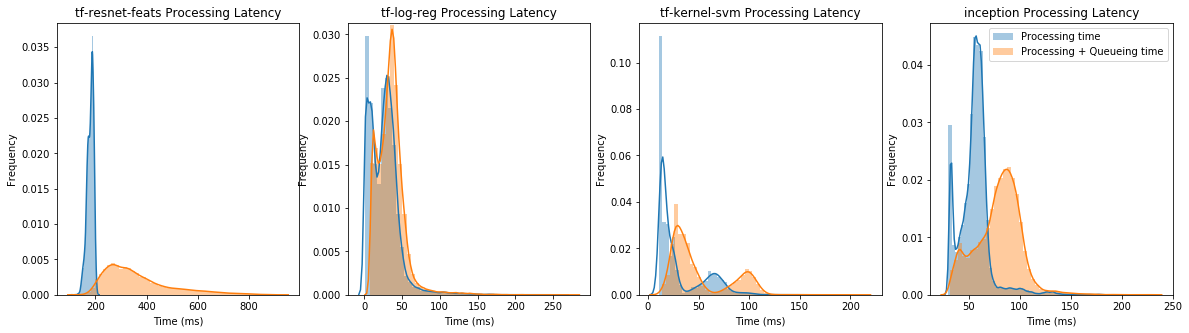

In [75]:
compare_latency_dists(ID1_500, image_driver_1_models)

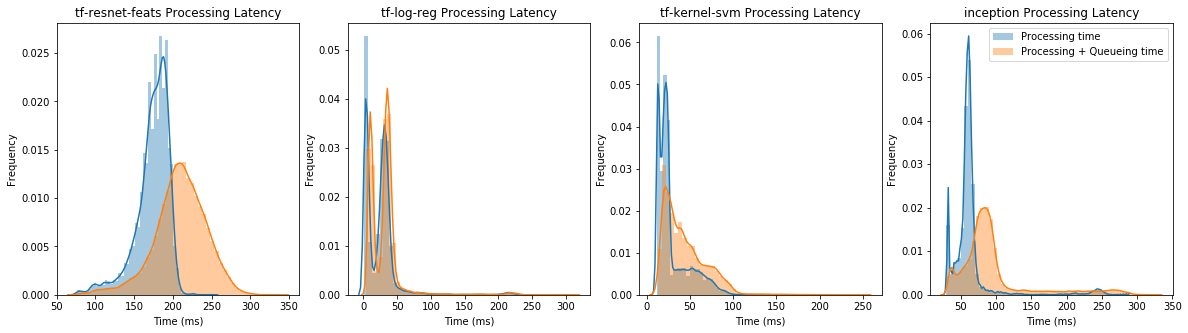

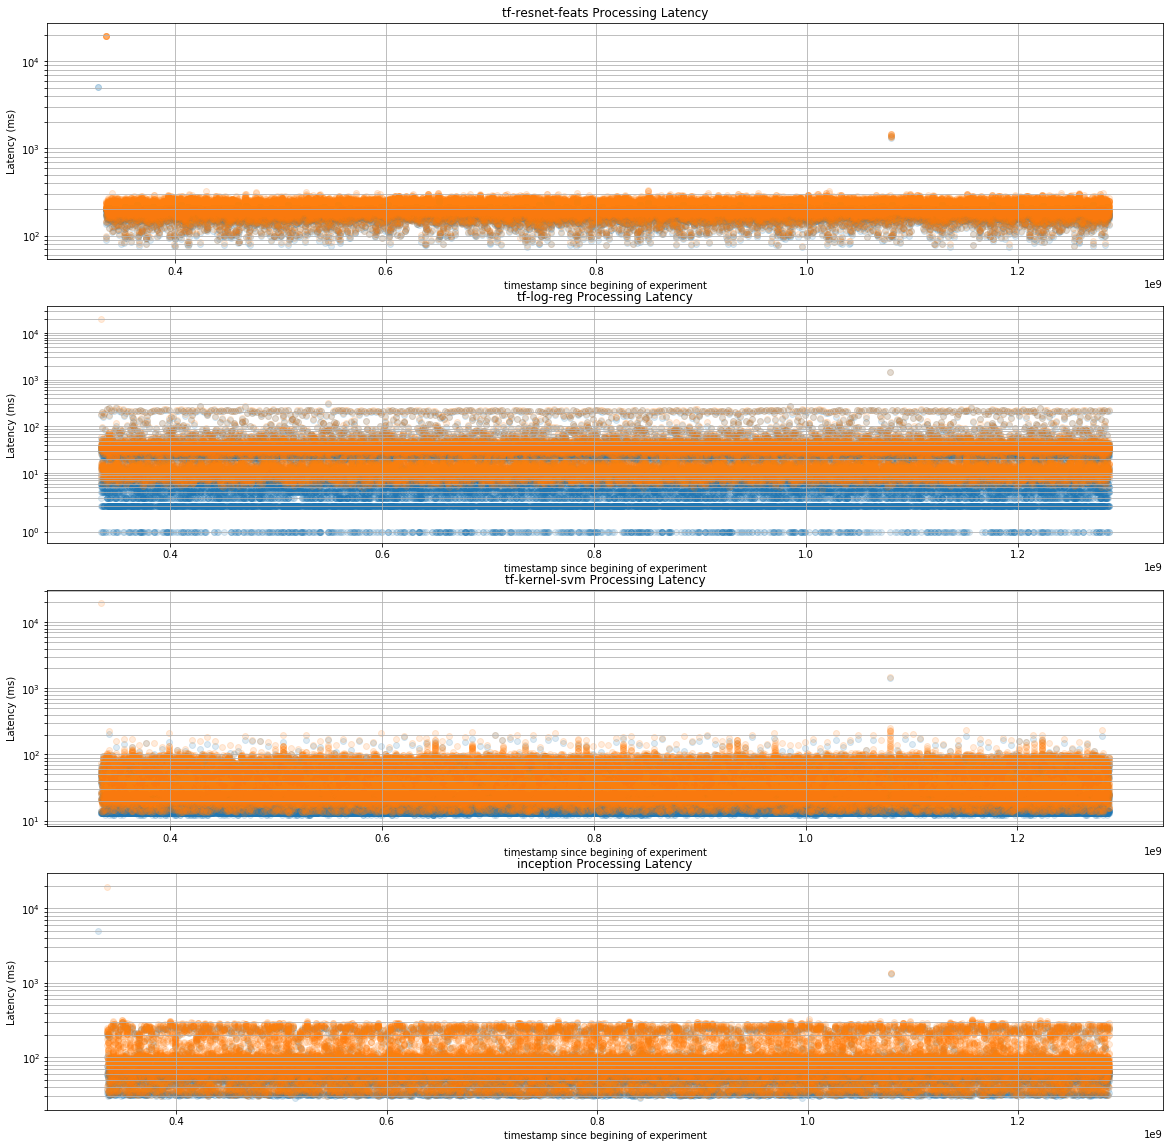

In [71]:
compare_latency_dists(ID1_500_resnet2, image_driver_1_models)
compare_latency_dists_over_time(ID1_500_resnet2, image_driver_1_models)

In [10]:
def get_intervals(cached_extractions, model, intra_batch_arrivals):
    arrivals = cached_extractions[model+":1:queue_arrivals"][:,1]
    timestamps = cached_extractions[model+":1:queue_arrivals"][:,0]
    timestamps = timestamps[1:] # taking the timestamp at arrival
    intervals = arrivals[1:] - arrivals[:-1]
    intervals = intervals/1000 # to ms
    if not intra_batch_arrivals:
        minimum_processing_time = np.min(cached_extractions[model+":processing_latency"][:,1])
        MIN = 2.5
        if minimum_processing_time < MIN:
            print "{model} processing time is too low (<{MIN}ms) to acceptably discern inter and intra batch arrivals".format(model=model, MIN=MIN)
            return intervals, timestamps # minimum processing time too close to the cut off, might be getting rid of inter-batch arrivals
        cutoff = MIN
        assert len(intervals) == len(timestamps)
        num_below = np.sum((intervals < cutoff).astype(int))
        above_mask = intervals >= cutoff
        intervals = intervals[above_mask]
        timestamps = timestamps[above_mask]
        print "{model}: Removed {num} points below {time} ms".format(model=model, num=num_below, time=cutoff)
    return intervals, timestamps
    
def plot_inter_arrival(cached_extractions, model_list, intra_batch_arrivals=True):
    plt.figure(figsize=(8,8))
    plt.title("Inter-arrival time")
    plt.xlabel("Inter-arrival time (ms)")
    plt.ylabel("Frequency")
    for model in model_list:
        intervals, _ = get_intervals(cached_extractions, model, intra_batch_arrivals)
        CV = np.var(intervals)/np.square(np.mean(intervals))
        smoothLineHistogram(intervals, label=model+str(" CV="+str(CV)))
    plt.legend()
    plt.show()

def plot_inter_arrival_over_time(cached_extractions, model_list, intra_batch_arrivals=True):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        intervals, timestamps = get_intervals(cached_extractions, model, intra_batch_arrivals)
        CV = np.var(intervals)/np.square(np.mean(intervals))
        plt.title(model+" Inter-arrival time")
        plt.xlabel("Position")
        plt.ylabel("Inter-arrival time (ms)")
        needlog = True #np.max(intervals) - np.min(intervals) > 10
        bounds = np.asarray([np.min(intervals), np.max(intervals)])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        plt.scatter(timestamps, intervals, label="CV="+str(CV), alpha = 0.3)
        plt.legend()
    plt.show()


In [ ]:
plot_inter_arrival_over_time(ID1_500, image_driver_1_models, intra_batch_arrivals=True)
plot_inter_arrival(ID1_500, image_driver_1_models, intra_batch_arrivals=True)

In [21]:
def plot_queue_sizes(cached_extractions, model_list, log=False):
    plt.figure(figsize=(8,8))
    plt.title("Queue length")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    if log:
        plt.xscale("log")
    for model in model_list:
        sizes = cached_extractions[model+":1:queue_sizes"]
        plt.hist(sizes, label=model,alpha=0.3)
    plt.legend()
    
def plot_ordinal_queue_sizes(cached_extractions, model_list):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        sizes = cached_extractions[model+":1:queue_sizes"][:,1]
        timestamps = cached_extractions[model+":1:queue_sizes"][:,0]
        plt.title(model+" Queue length")
        plt.xlabel("Position")
        plt.ylabel("Length")
        needlog = np.max(sizes) - np.min(sizes) > 10
        bounds = np.asarray([np.min(sizes), np.max(sizes)])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        plt.scatter(timestamps, sizes, label=model, alpha = 0.3)

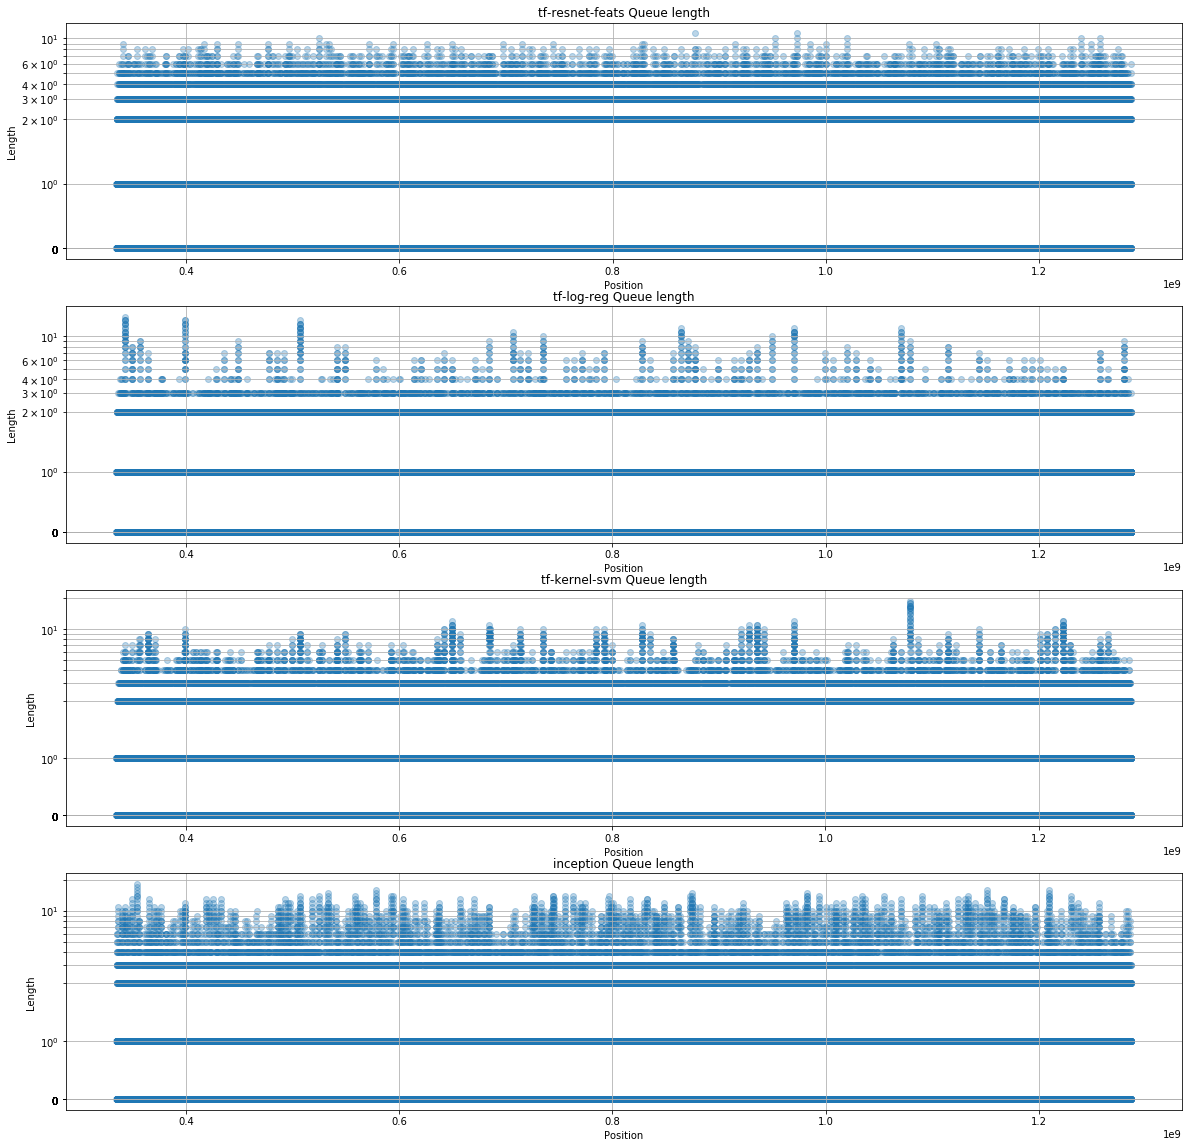

In [23]:
plot_ordinal_queue_sizes(ID1_500_resnet2, image_driver_1_models)

In [24]:
def plot_e2e_lats(cached_extractions):
    plt.figure(figsize=(8,8))
    plt.title("e2e Latencies")
    lats = cached_extractions["e2e_lats"]
    plt.plot(np.arange(len(lats)), lats)
    plt.xlabel("Experiment iteration")
    plt.axhline(y=0.5, color='r', linestyle='--', )
    plt.ylabel("Latency (ms)")

In [5]:
def get_max_curve(timestamps, trial_range):
    def get_smallest_delta_2(time_range, timestamps):
        head_index = 0 # the first index less than or equal to time_range's higher end
        tail_index = 0 # the first index less than or equal to time_range's lower end
        position = 'tail' # start when time_range's lower end (tail) is aligned with a point
        contained_currently = 1 # a single point (the first index) must be contained in the time_range
        # add the rest of the timepoints contained in time_range
        for i in xrange(tail_index+1, len(timestamps)):
            if timestamps[i] <= timestamps[tail_index] + time_range:
                contained_currently+=1
                head_index+=1
            else:
                break
        max_so_far = contained_currently
        while head_index < len(timestamps)-1: # this means time_range's higher end hasn't exceeded the very last timestamp
            if position == "tail":
                head_time_position = timestamps[tail_index] + time_range
                head_delta = timestamps[head_index+1] - head_time_position
                assert head_delta > 0 or np.isclose(head_delta, 0)
                tail_delta = timestamps[tail_index+1] - timestamps[tail_index]
            elif position == "head":
                tail_time_position = timestamps[head_index] - time_range
                tail_delta = timestamps[tail_index+1] - tail_time_position
                assert tail_delta >= 0  or np.isclose(tail_delta, 0)
                head_delta = timestamps[head_index+1] - timestamps[head_index]
            if tail_delta < head_delta:
                position = "tail"
                tail_index = tail_index + 1 # head_index stays the same
                contained_currently-=1
            elif head_delta <= tail_delta:
                position = "head"
                head_index = head_index + 1 # tail_index stays the same
                contained_currently+=1
            assert contained_currently >= head_index-tail_index
#             print tail_index, head_index, position, contained_currently, max_so_far
            if contained_currently > max_so_far:
                max_so_far = contained_currently
        return max_so_far
    y_axis = np.asarray([get_smallest_delta_2(float(i), timestamps) for i in trial_range])
    x_axis = np.asarray(list(trial_range))
    return x_axis, y_axis

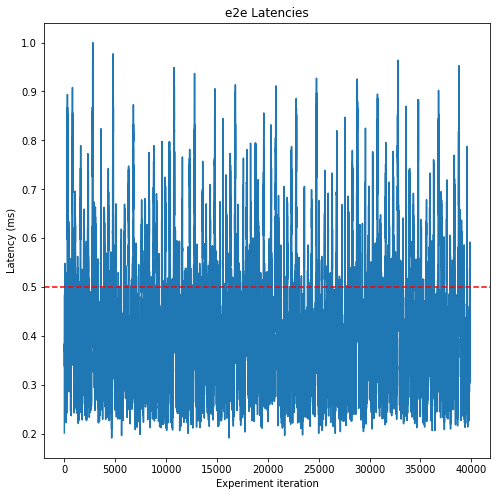

In [68]:
plot_e2e_lats(ID1_500_hollistic)

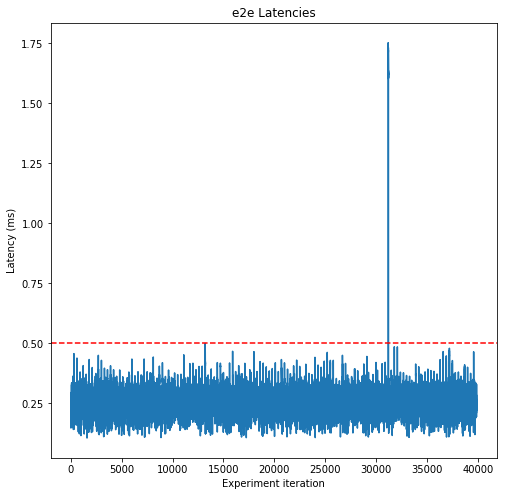

In [69]:
plot_e2e_lats(ID1_500_hollistic_resnet2)

In [6]:
[(k, len(v)) for k,v in ID1_500_hollistic["client_timestamps"].iteritems()]

[('start->tf-resnet-feats_timestamps', 40000),
 ('inception->tf-log-reg_timestamps', 39999),
 ('start->inception_timestamps', 40000),
 ('tf-kernel-svm->join_timestamps', 39997),
 ('join->end_timestamps', 39997),
 ('tf-log-reg->join_timestamps', 39998),
 ('tf-resnet-feats->tf-kernel-svm_timestamps', 39998)]

In [35]:
x_range = xrange(1,5000,25)
resnet_arrival = ID1_500_hollistic["client_timestamps"]["start->tf-resnet-feats_timestamps"]*1000.
resnet_departure = ID1_500_hollistic["client_timestamps"]["tf-resnet-feats->tf-kernel-svm_timestamps"]*1000.
x_arrival_resnet, y_arrival_resnet = get_max_curve(resnet_arrival, x_range)
x_departure_resnet, y_departure_resnet = get_max_curve(resnet_departure, x_range)

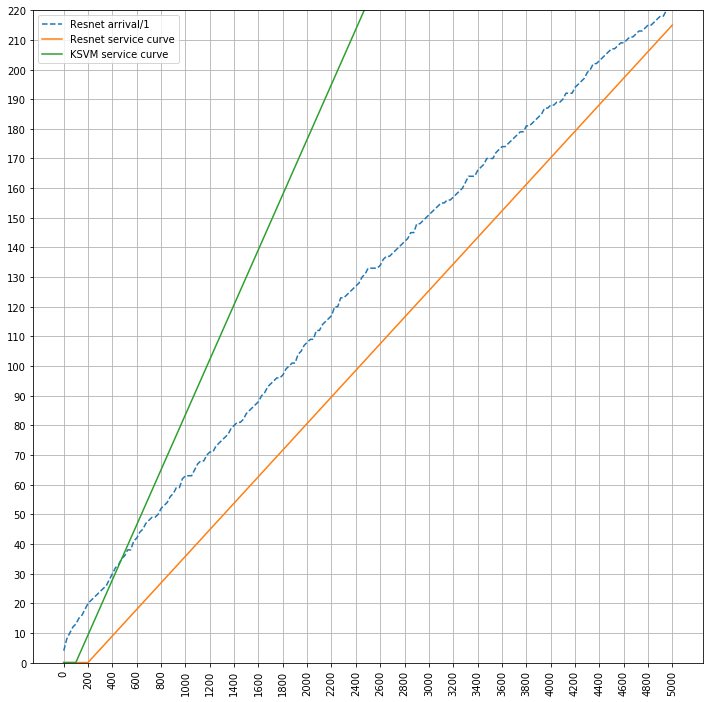

In [77]:
plt.figure(figsize=(12,12))
plt.xticks(xrange(0,5200,200))
plt.xticks(rotation=90)
plt.gca().set_ylim([0,220])
plt.yticks(xrange(0,225,10))
plt.grid(True)
plt.plot(x_arrival_resnet, y_arrival_resnet/1, label="Resnet arrival/1", linestyle="--")
# plt.plot(x_arrival_resnet, y_arrival_resnet/2, label="Resnet arrival/2", linestyle="--")
plt.plot([0,200,5000],[0,0,5*43], label="Resnet service curve")
plt.plot([0,100,5000],[0,0,5*91], label="KSVM service curve")
# plt.plot([0,50,5000],[0,0,5*910], label="LogReg service curve")
# plt.plot([0,150,5000],[0,0,5*106], label="Inception service curve")
plt.legend()

In [60]:
x_range = xrange(1,15000,25)
resnet2_arrival = ID1_500_hollistic_resnet2["client_timestamps"]["start->tf-resnet-feats_timestamps"]*1000.
# resnet2_departure = ID1_500_hollistic_resnet2["client_timestamps"]["tf-resnet-feats->tf-kernel-svm_timestamps"]*1000.
x_arrival_resnet2, y_arrival_resnet2 = get_max_curve(resnet2_arrival, x_range)
# x_departure_resnet2, y_departure_resnet2 = get_max_curve(resnet2_departure, x_range)

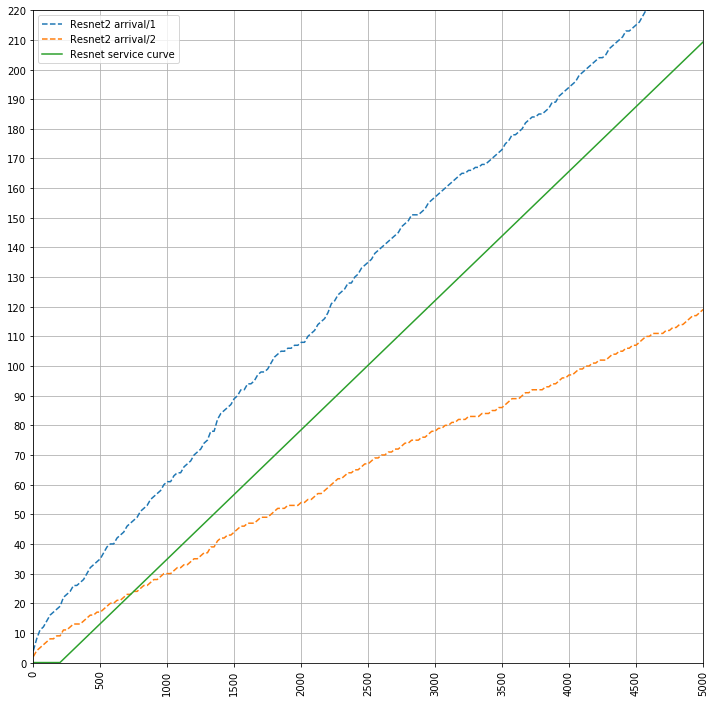

In [79]:
plt.figure(figsize=(12,12))
plt.xticks(xrange(0,max(x_range),500))
plt.xticks(rotation=90)
plt.yticks(xrange(0,np.max(y_arrival_resnet2),10))
plt.gca().set_xlim([0,5000])
plt.gca().set_ylim([0,220])
plt.grid(True)
plt.plot(x_arrival_resnet2, y_arrival_resnet2, label="Resnet2 arrival/1", linestyle="--")
plt.plot(x_arrival_resnet2, y_arrival_resnet2/2, label="Resnet2 arrival/2", linestyle="--")
plt.plot([0,200,max(x_range)],[0,0,max(x_range)/1000.*43], label="Resnet service curve")
# plt.plot([0,100,5000],[0,0,5*91], label="KSVM service curve")
# plt.plot([0,50,5000],[0,0,5*910], label="LogReg service curve")
# plt.plot([0,150,5000],[0,0,5*106], label="Inception service curve")
plt.legend()